# 17 Deep networks for natural language processing

Part of ["Introduction to Data Science" course](https://github.com/kupav/data-sc-intro) by Pavel Kuptsov, [kupav@mail.ru](mailto:kupav@mail.ru)

Recommended reading for this section:

1. A. Kedia and M. Rasu (2020) Hands-On Python Natural Language Processing. Packt Publishing

The following Python modules will be required. Make sure that you have them installed.
- `matplotlib`
- `requests`
- `tensorflow`
- `re`
- `sklearn`
- `json`
- `zipfile`
- `nltk`
- `spacy`
- `gensim`
- `numpy`

This lecture will closely follow the book \[1\].

## Lesson 1

### Required initialization and helper functions

Before we begin some initialization is required

In [ ]:
import tensorflow as tf

In [ ]:
# This initialization code is required due to an error 
# "NotFoundError: No algorithm worked"
# when using Conv2D
# Probabliy due to problems with cuda 11.
# Remove this when fixed
# https://github.com/tensorflow/tensorflow/issues/43174
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Dropout, LSTM, Embedding, GRU, SimpleRNN
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.preprocessing.sequence import pad_sequences

The function `plot_hist` below plots learning curves: loss and accuracy vs. epoch of training.

It accepts a lits of training histories `hist_list` computed for different networks and plots them as rows of images.

In [ ]:
import matplotlib.pyplot as plt

def plot_hist_one(hist, name, axs):
    """Plot one loss and accuracy"""
    epochs = len(hist.history['loss'])
    xs = list(range(epochs))
    
    ax = axs[0]
    ax.plot(xs, hist.history['loss'], label='loss')
    ax.plot(xs, hist.history['val_loss'], label='val_loss')
    ax.set_ylabel('loss')
    ax.set_yscale('log')

    ax = axs[1]
    ax.plot(xs, hist.history['accuracy'], label='accuracy');
    ax.plot(xs, hist.history['val_accuracy'], label='val_accuracy');
    ax.set_ylabel('accuracy')

    for ax in axs:
        ax.grid()
        ax.set_xlabel('epoch')
        ax.legend(title=name)    

def plot_hist(hist_list, hist_names):
    """Plot loss and accuracy for many network"""
    N = len(hist_list)
    fig, axs = plt.subplots(nrows=N, ncols=2, figsize=(10, 3*N))
    if N == 1:
        axs = [axs]
    for hist, name, ax in zip(hist_list, hist_names, axs):
        plot_hist_one(hist, name, ax)
    plt.tight_layout()

### Dense network for document classification

In this section we will consider supervised learning model able to perform classification of documents.

We will learn it to to classify questions. 

The training dataset is a corpus of questions labeled by one of six categories. 

The purpose is to create a model that accepts a question as its input and predicts its category at the output.

Obviously taking other datasets one can use this approach to train a spam filter or create a model for sentiment analysis.

We need a function for downloading a dataset from a course repository.

In [ ]:
import requests
import matplotlib.pyplot as plt

def load_txt_dataset(file_name, dtype=float):
    """Downloads txt dataset from repo."""
    base_url = "https://raw.githubusercontent.com/kupav/data-sc-intro/main/data/"
    web_data = requests.get(base_url + file_name)
    assert web_data.status_code == 200
    return web_data.text.splitlines()

The dataset we use is found at url https://cogcomp.seas.upenn.edu/Data/QA/QC/ and copied to the course repository for convenience.

Let us download the dataset and what is it.

In [ ]:
raw_corpus = load_txt_dataset("illinois_univ_lab_quest.txt")
for doc in raw_corpus[:10]:
    print(doc)
print(f"\nTotally {len(raw_corpus)} records")

We have a list of records, each one contains a questions itself and its category. 

The lits of the categories is
- ABBREVIATION
- ENTITY
- DESCRIPTION
- HUMAN
- LOCATION
- NUMERIC

Moreover each category is supplied with a more fine features after column, e.g. "DESC:manner" or "ABBR:exp". 

We will omit them and preserve only the coarse classes written with capital letters.

We need to parse each line to split questions and their categories.

It can be done with a regular expressions with the pattern `([A-Z]+):[a-z]+\s(.+)`

Before processing the whole corpus let us see how it works.

It has two blocks wrapped with parentheses: `([A-Z]+)` and `(.+)`. They are called groups and highlight what we want to catch:

- `([A-Z]+)`: the first group matches one or more capital letters staring from the very beginning. It will catch category names.
- `:[a-z]+\s`: colon followed by one or more lowercase letters followed by space. It matches fine category description that have to be omitted.
- `(.+)`: the second group to catch, any letters up to the end.

Here is an example that shows how it works.

In [ ]:
import re

rge = re.compile(r"([A-Z]+):[a-z]+\s(.+)")

for doc in raw_corpus[:10]:
    print(rge.findall(doc))

Now we are ready to extract lists of questions and category names from our corpus.

In [ ]:
import re

txt = raw_corpus[:10]

rge = re.compile(r"([A-Z]+):[a-z]+\s(.+)")

quests = []
categs = []
for doc in raw_corpus:
    result = rge.findall(doc)
    categs.append(result[0][0])
    quests.append(result[0][1])

for c, q in zip(categs[:10], quests[:10]):    
    print(c, q)

Let us analyze what are the questions and what are the categories.

For convenience we define a dictionary that maps shorten forms of category names and print several questions from each category

In [ ]:
full_categ_names = {"ABBR": "ABBREVIATION", "ENTY": "ENTITY", "DESC": "DESCRIPTION", 
                    "HUM": "HUMAN",  "LOC": "LOCATION", "NUM": "NUMERIC"}

unique_categs = list(set(categs))
N = 10
for extracted_categ in unique_categs:
    tmp = [q for q, c in zip(quests, categs) if c==extracted_categ]
    print(full_categ_names[extracted_categ])
    for q in tmp[:N]:
        print(f"\t{q}")

As we discussed in previous lectures predicting categories requires converting them into one-hot form.

There many ways to do it. Both tensorflow and numpy libraries provide the corresponding function. 

Let us check show it can be done using sklearn.

This library suggests a class `OneHotEncoder` that converts a series of categorical features into one one-hot vectors.

Here is an illustration:

In [ ]:
from sklearn.preprocessing import OneHotEncoder

test = [['Male', 'Young'], ['Female', 'Young'], ['Female', 'Adult']]

enc = OneHotEncoder()
enc.fit(test)
print(enc.categories_)
print(enc.transform(test).toarray())

If there is only one categorical features it still must be wrapped into a list like this:

In [ ]:
from sklearn.preprocessing import OneHotEncoder

test = [['Baby'], ['Young'], ['Adult']]  # not just ['Baby', 'Young', 'Adult']

enc = OneHotEncoder()
enc.fit(test)
print(enc.categories_)
print(enc.transform(test).toarray())

We are ready to create one-hot vectors for our categories:

In [ ]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
categs1 = [[c] for c in categs]
encoder.fit(categs1)
print(encoder.categories_)
num_categs = encoder.categories_[0].shape[0]
print(num_categs)

labels = encoder.transform(categs1).toarray()
print(labels)

Now the questions have to be prepared: cleaning, tokenization and normalization have be done.

We take a copy of function for cleaning and tokenization from the previous lecture.

In [ ]:
import nltk

def tokenize_and_clean(sentence):
    """Tokenize sentence and clean it.
    """
    raw_tokens = nltk.word_tokenize(sentence)
    tokens = []
    for tok in raw_tokens:
        t1 = tok[1:] if tok[0] == "'" else tok  # we do not want to remove tokens like "'ve" 
        if t1.isalpha():
            tokens.append(tok.lower())
    return tokens

Now we create TF-IDF representation for questions. 

We copy a code from a previous lecture with a small modification: cleaning has been added and nltk tokenizer is used.

Removing stopwords we have to preserve "wh-" words: we are dealing with questions and these words are meaningful.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('stopwords')

stemmer = nltk.stem.snowball.SnowballStemmer(language = 'english')

wh_words = set(['who', 'what', 'when', 'why', 'how', 'which', 'where', 'whom'])
stop = set(nltk.corpus.stopwords.words('english')) - wh_words

def stemmed_tokenizer(doc):
    raw_tokens = tokenize_and_clean(doc)
    tokens = [tok for tok in raw_tokens if tok not in stop]
    stem_tokens = [stemmer.stem(tok) for tok in tokens]
    return stem_tokens

vectorizer = TfidfVectorizer(tokenizer=stemmed_tokenizer)
tfidf_quests = vectorizer.fit_transform(quests);

The result of the vectorization is a matrix of TF-IDF vectors, one row for one question. 

In [ ]:
print(tfidf_quests.toarray().shape)
print(labels.shape)

Split the whole dataset into testing and training parts.

In [ ]:
from sklearn.model_selection import train_test_split

p_test = 0.1
n_test = round(p_test * labels.shape[0])

X_train, X_test, y_train, y_test = train_test_split(tfidf_quests.toarray(), labels, random_state=0, 
                                                    test_size=n_test, shuffle=True)

print(f"train size {len(y_train)}")
print(f" test size {len(y_test)}")

Now everything is ready to create and train a model.

It will be simple two layer model.

However, preliminary tests have shown that it is prone to a strong overfitting. 

We fight it using two tools. 

First is already known dropout. Let us remember that it temporarily stops training of some of neurons and thus force model to find generalization of the data instead of mere remembering.

Another remedy is regularization of neuron weights: observe parameter `tf.keras.regularizers.l2` of the first dense layer.

It adds sum of squared neuron weights directly to the loss function multiplied by the coefficient `l2=0.01`. 

This coefficient controls the penalty level applied for too high by magnitude values of weights.

As a result during training the optimization algorithm seeks for the minimum of the loss function provided that the neuron coefficients are as small as possible.

It reduces the information capacity of a network and thus reduces the overfitting.

In [ ]:
input_shape = X_train.shape[1:]

model = Sequential([
    Dense(256, input_shape=input_shape, activation='relu', 
          kernel_regularizer=tf.keras.regularizers.l2(l2=0.01)),
    Dropout(0.8),
    Dense(num_categs)
])

model.compile(optimizer='adam',  
             loss=CategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

model.summary()

In [ ]:
hist = model.fit(X_train, y_train, epochs=50, validation_split=0.2, verbose=2)

In [ ]:
plot_hist([hist], ["questions classification"])

In [ ]:
acc, loss = model.evaluate(X_test, y_test)
print(f"acc={acc}, loss={loss}")

We have trained our model not so long so its accuracy is at the level of 80\%. More epochs of training are required to attain higher performance.

Let us check how the model can work.

Here the steps that are required to ask a model to predict a question category:

In [ ]:
q1 = "Who Framed Roger Rabbit?"

vec = vectorizer.transform([q1]).toarray()
y_pred = model.predict(vec)
print(y_pred)
cat_pred = tf.argmax(y_pred, axis=1).numpy()
print(cat_pred)
cat_pref = cat_pred[0]
encoder.categories_[0][cat_pred]

We can wrap all this into a function and test it with various questions.

In [ ]:
def classify(quest, model, vectorizer, encoder):
    vec = vectorizer.transform([q1]).toarray()
    y_pred = model.predict(vec)
    cat_pred = tf.argmax(y_pred, axis=1).numpy()[0]
    return encoder.categories_[0][cat_pred]    

In [ ]:
q1 = "Who Framed Roger Rabbit?"
print(classify(q1, model, vectorizer, encoder))

In [ ]:
q1 = "How far is the sun?"
print(classify(q1, model, vectorizer, encoder))

In [ ]:
q1 = "MNIST, is this an abbreviation or what?"
print(classify(q1, model, vectorizer, encoder))

In [ ]:
q1 = "I wonder where I put my glasses"
print(classify(q1, model, vectorizer, encoder))

Our model is very simple. What can be done to improve it?

First of all more accurate cleaning is required. Probably dots must be preserved in tokens representing domain names like ".com". 

Since abbreviations are essential in this corpus, it is better to avoid their conversion to lowercase.

Replacing stemming with lemmatisation will probably also improve the performance.

Vector model TF-IDF is not the best one known today. Embedding models `Doc2Vec` or `Sent2Vec` are expected to work better.

Finally one can also play with the network structure: add more layers, change layer sizes, increase or decrease regularization coefficient and dropout ratio.

### Convolutional network for document classification

Previously we considered convolutional network for images classification. 

Similarly convolution can be leveraged to texts. 

Each sentence (or a document) of a corpus can be represented as word vectors that are stacked one after another. 

Convolution kernel has width corresponding to the length of a word vector and height equal to an odd number (typically) to grab together with the current vector two or more its neighbors.

After convolution new vector size equals to the number of filters (kernels) applied. Sentence length is unchanged if zero padding is used.

This is called 1 dimensional convolution.

Also 1 dimensional pooling is applied after the convolution. 

Pooling is applied along sentences, separately along each vector element. 

The pooling reduces the length of sentences. The reduction coefficient depends on the pooling widow size. Typically this is 2.

As usual there are average or max pooling.

Global pooling has a window size equal to the number of sentences. Its result is a single vector.

![convol_1d.svg](fig/convol_1d.svg)

In this section we consider text classification problem. 

Notice that the same problem was consider in the previous section. 

The difference is that now we will consider how convolutions can be used for this.

We will build sarcasm detector. 

The dataset is taken from Kaggle at https://www.kaggle.com/rmisra/news-headlines-dataset-for-sarcasm-detection
and copied to a course repository for convenience.

This dataset is collected from two news website. First is TheOnion that aims at producing sarcastic versions of current events and HuffPost that publishes real (and non-sarcastic) news.

Only headlines of news are gathered.

Let us first download zipped file and open it as Python list.

The file has format JSON. This is an open standard file format, and data interchange format, that uses human-readable text to store and transmit data objects.

To read and parse it we use Python library `json`. The outcome is Python dictionaries representing each data record.

In [ ]:
import json
import requests
from io import BytesIO, TextIOWrapper
from zipfile import ZipFile

def load_ziptxt_dataset(file_name):
    """Downloads zipped dataset from repo and return it as a text."""
    base_url = "https://raw.githubusercontent.com/kupav/data-sc-intro/main/data/"
    web_data = requests.get(base_url + file_name)
    assert web_data.status_code == 200

    # unzip the content
    zf = ZipFile(BytesIO(web_data.content))
    
    # zipped file name
    zipped_name = zf.namelist()[0]
    print(f"Download {file_name}, unzip {zipped_name}")
    
    # Open unpacked file
    with zf.open(zipped_name, 'r') as file:
        # TextIOWrapper(file) converts byte strings to plain strings
        data = []
        for record in TextIOWrapper(file):
            data.append(json.loads(record))
    return data

In [ ]:
raw_data = load_ziptxt_dataset("Sarcasm_Headlines_Dataset_v2.json.zip")
print(f"Number of records {len(raw_data)}")

print()
for record in raw_data[:5]:
    print(record)

We see that there three fields: "is_sarcastic", "headline" and "article_link". 

We will use only first two omitting article links.

In [ ]:
alllabels = []
documents = []

for record in raw_data:
    alllabels.append(int(record['is_sarcastic']))
    documents.append(record['headline'])

Check the balance: if we have same number of sarcastic and non sarcastic news.

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.hist(alllabels, bins=2);

Now we need to preprocess documents.

Since we will use Word2Vec vectorization stemming is not appropriate since Word2Vec models are built for full words, not for their stems.

So we perform lemmatization with the help of `spacy`.

After lemmatization a cleaning is performed using the pattern `[a-z]+`.

This is very aggressive cleaning that remove every token not including only letters.

Notice that the reduced verbs with apostrophe like "'ve" are also removed. 

This is because at the next step remove stopwords according to a nltk list where all such modal verbs are present.

In [ ]:
import re
import spacy
import nltk
nltk.download('stopwords')

nlp = spacy.load('en_core_web_sm')
stop = set(nltk.corpus.stopwords.words('english'))
rge = re.compile("[a-z]+")

def preproc(sentence, nlp, stop, rge):
    nlp_tokens = nlp(sentence)
    tokens = [token.lemma_ for token in nlp_tokens]
    tokens = [tok for tok in tokens if rge.fullmatch(tok) is not None]
    tokens = [tok for tok in tokens if tok not in stop]
    return tokens

This code applies the preprocessor to the documents. Sometimes it removes all sentence, sometimes only one or to tokens left. 

Such short documents are ignored, since sarcasm is sufficiently complicated construct that requires many words to be expressed.

In [ ]:
# It takes some time
min_length = 3
tokens, labels = [], []
for lab, doc in zip(alllabels, documents):
    toks = preproc(doc, nlp, stop, rge)
    if len(toks) >= min_length:
        tokens.append(toks)
        labels.append(lab)
    
print(tokens[:10])

Vectorization will be done using prebuilt Word2Vec model provided by `gensim`. 

Below there are two version. 

Calling the better and the larger model "word2vec-google-news-300" is commented out to avoid large traffic.

In [ ]:
import gensim.downloader as api

vectorizer = api.load("glove-wiki-gigaword-50")  # 66 MB
# vectorizer = api.load("word2vec-google-news-300")  # 1.7 GB !

This function below computes vector representation of sentences. 

Since sentences have different sizes we take some value `max_length` as the largest sentence length taken into account.

Longer sentences are truncated and shorter ones are padded with zero vectors.

Some words may be not found in the vocabulary of the Word2Vec model. In such cases we put a stub instead: a random vector that is required to indicate that here there is some word.

In [ ]:
import numpy as np
rng = np.random.default_rng(seed=0)
stub = rng.uniform(-1,1, size=vectorizer.vector_size)

def vectorize_data(data, vectorizer, max_length, stub):
    vector_size = vectorizer.vector_size
    vectors = []
    padding_vector = [0.0] * vector_size
    
    for i, data_point in enumerate(data):
        data_point_vectors = []
        count = 0
        
        for token in data_point:
            if count >= max_length:
                break
            if vectorizer.get_index(token, default=-1) >= 0:
                data_point_vectors.append(vectorizer[token])
            else:
                data_point_vectors.append(stub)
            count = count + 1
        
        if len(data_point_vectors) < max_length:
            to_fill = max_length - len(data_point_vectors)
            for _ in range(to_fill):
                data_point_vectors.append(padding_vector)
        
        vectors.append(data_point_vectors)
        
    return np.array(vectors)

Maximum length of sentence that we take into account is computed as 90 percentile of the distribution of sentence lengths. 

It means that 90\% of sentences has the length no longer then this.

The reason that we do not take the longest sentence is that there are few very large sentences and we do not want to enlarge the model due to them.

In [ ]:
sizes = [len(sent) for sent in tokens]
print(max(sizes))
max_length = sorted(sizes)[9*len(tokens)//10]
print(max_length)

This is the vectorization:

In [ ]:
tokvecs = vectorize_data(tokens, vectorizer, max_length, stub)
print(tokvecs.shape)

Now we split the dataset into training and testing parts.

In [ ]:
from sklearn.model_selection import train_test_split

p_test = 0.3
n_test = round(p_test * len(labels))

X_train, X_test, y_train, y_test = train_test_split(tokvecs, np.array(labels), random_state=0, 
                                                    test_size=n_test, shuffle=True)

print(f"train shape {X_train.shape}")
print(f"test shape {X_test.shape}")

And finally the model.

We use here one convolution layer accompanied by global pooling and two dense layers. 

Overfitting is reduced via dropouts and neuron weights reducing.

Since there are two classes to predict the loss function is binary cross entropy.

In [ ]:
input_shape = X_train.shape[1:]
l2_penalty = 0.01
dropout_rate = 0.5

model = Sequential([
    Conv1D(input_shape=input_shape,
           filters=8, kernel_size=3, padding='same', activation='relu',
           kernel_regularizer=tf.keras.regularizers.l2(l2_penalty)),
    GlobalMaxPooling1D(),
    Dense(10, activation='relu',
          kernel_regularizer=tf.keras.regularizers.l2(l2_penalty)),
    Dropout(dropout_rate),
    Dense(5, activation='relu',
          kernel_regularizer=tf.keras.regularizers.l2(l2_penalty)),
    Dropout(dropout_rate),
    Dense(1)
])

model.compile(optimizer='adam',  
             loss=BinaryCrossentropy(from_logits=True),
             metrics=['accuracy'])

model.summary()

In [ ]:
hist = model.fit(X_train, y_train, epochs=50, validation_split=0.2, verbose=2)

In [ ]:
plot_hist([hist], ["sarcasm"])

In [ ]:
acc, loss = model.evaluate(X_test, y_test)
print(f"acc={acc}, loss={loss}")

Let us now apply the model to a arbitrary expressions.

First consider the steps with printing intermediate results.

In [ ]:
ss = "You look so good, really"

tok = preproc(ss, nlp, stop, rge)
print(tok)
vec = vectorize_data([tok], vectorizer, max_length, stub)
print(vec)
y_pred = model.predict(vec)
print(y_pred)
print("sarcastic" if y_pred[0][0] < 0 else "non sarcastic")

The steps can be wrapped to a functions

In [ ]:
def classify(ss):
    tok = preproc(ss, nlp, stop, rge)
    if len(toks) < min_length:
        raise ValueError
    vec = vectorize_data([tok], vectorizer, max_length, stub)
    y_pred = model.predict(vec)
    return "sarcastic" if y_pred[0][0] < 0 else "non sarcastic"

Now the examples

In [ ]:
ss = "Marry had a little lamb, little lamb, little lamb"
print(classify(ss))

In [ ]:
ss = "That's just what I needed today!"
print(classify(ss))

In [ ]:
ss = "Well, what a surprise."
print(classify(ss))

In [ ]:
ss = "Great! I hope I'm a waitress at the Cheesecake Factory for my whole life!"
print(classify(ss))

In [ ]:
ss = "NaNs are treated as missing values: disregarded in fit, and maintained in transform."
print(classify(ss))

In [ ]:
ss = "Fender releases new hybrid gas-electric guitar"
print(classify(ss))

In [ ]:
ss = "You can now message the president on facebook"
print(classify(ss))

We see that the predictions often do not correspond to our intuition.

The model obviously have to be improved.

Probably detection of sarcasm requires all words in sentences so we may try to make cleaning and stopwords removal not so aggressive.

It is reasonable to try to refuse the removing of the stop words.

The lemmatization can be also the problem.

Let us remember: stemming or lemmatizaton are required to reduce the vocabulary size and thus the vector size in Bag of Words and TF-IDF models. 

When embedding models are used this problem is absent. 

And the embedding model are built on the raw texts without lemmatization. 

Probably using sentences in their original form can help to make the detector more adequate.

Of course the model architecture can also be adjust: more convolution layers can be added and sizes of their kernels as well as sizes of dense layers can be tuned up.

In particular probably the size of convolution kernel mater. Larger size means taking into account more word context. One can try sentence-wide kernels.

Multiple convolutions with small kernels play the same role. Applying convolution again and again we take into account more and more word neighbors.

### Recurrent neural networks

Texts is built of sequences: sentence is a sequence of words, paragraph is a sequence of sentences and so on.

Elements of sequences depend on each other: meaning of a word depends on other words in the sentence. 

Using plain dense layers is not so easy to take it into account. We can only do it if perform text vectorization that takes into account neighbors, e.g., use n-grams or word2vec.

Convolutional networks are better suitable for it. If kernel size is sufficiently large we can take much of word context. These type of layers can be used for text classification.

However convolutions have constant windows size and in text dependencies between words usually have varying lengths.

Let see and example:

- "She went on a walk along with her dog."
- "He went on a walk with his dog."

The usage of the term  "her" or "his" depend on the term "She" or "He". The distance between "her" and "She" is 7 words and the distance between "his" and "He" is 6 words. 

Convolution will probably be unable to take this dependence into account properly because two similar patterns has different scales to its opinion. 

Convolution is good only at constant scale structures like images.

There is another important problem in natural language processing: text generation. Some examples where it can be applied:
- annotation of images
- translation from one language to another
- answering customers questions

For this purpose both dense and convolutional layres are inappropriate. 

A special architecture is required that is suitable for sequences processing.

Such networks are called recurrent neural networks, RNN.

The idea of sequences processing with RNN: when an element of the sequence is processed and an output is generated the output in addition is sent to the next step and it is passed to network together with the next sequence element. 

It looks like a feedback loop. The output is sent the network input.

In the left part of a figure below a RNN unit has a external input $x_t$ and also a inner input $h_{t-1}$. They both are passed to the network and two outputs are produced, $y_y$ and $h_t$. Actually the external output $y_t$ is just somehow processed inner output $h_t$: $y_t=f(h_t)$. The $h_t$ is passed to the network together with new input $x_{t+1}$ and everything repeats. 

Notice that in the right part the described iterations are drawn in the unfolded form. But at each time step we use the same RNN unit with the same neurons parameters. 

![rnn.png](fig/rnn.png)
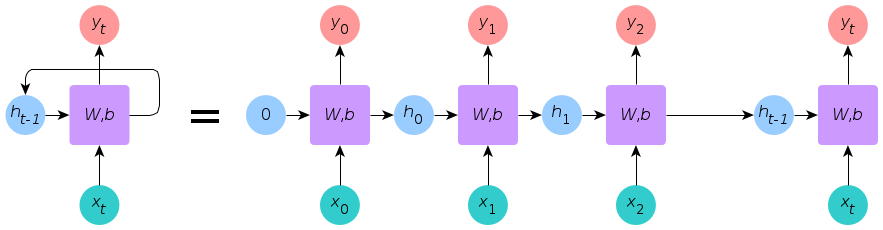

Mathematically RNN unit can be represented as a combination of dense layers. 

$$
h_t = f(x_t W + h_{t-1} U + b)
$$

$$
y_t = f(h_t V + c)
$$

Here $W$, $U$ and $V$ are matrices of neuron input weights, $b$ and $c$ are bias vectors and $f()$ denotes an activation function, e.g., sigmoid.

Repeat one more time: there is only one set of parameters $W$, $U$, $V$, $b$ and $c$. And they are applied again and again in the course of iterations.

Although RNN takes care about previous states of a sequence, information tends to decay. The influence of the sequence head almost vanishes at its tail. Another problem: sometimes the key word of a sentence appears at its tail so that meaning of the head words changes when we see the sentence end. 

In this situations __bidirectional__ RNN are used. These are just two independent RNN. One reads sequence from the beginning to the end and another reads it in the opposite direction. Then their outputs are merged somehow, usually by passing through another dense network layer.

### Types of RNN architecture

In the figures below absent input means zero input and absent output means its ignoring.

__One-to-many__. One input records is unrolled into a sequence. For example this is image annotation or music generation.

![rnn-task1.png](fig/rnn-task1.png)
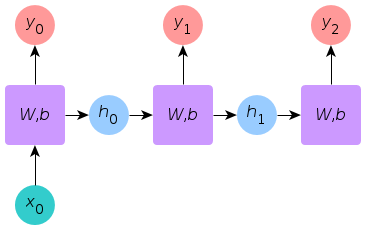

__Many-to-one__. Input sequence produces singe output. This is classification. For example - sentiment
analysis applications, wherein multiple words are fed into the network as input to produce an output 
depicting the sentiment from the input sentence.

![rnn-task2.png](fig/rnn-task2.png)
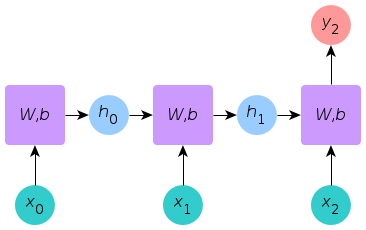

__Many-to-many with time shift__. Input sequences is processed and an output sequence is produced. Chatting or translation.

![rnn-task3.png](fig/rnn-task3.png)
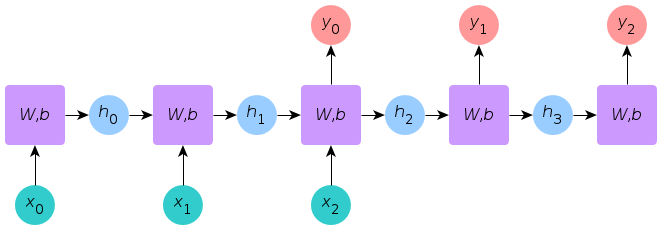

__Many-to-many synchronized__. Each element of the input sequence immediately produces an output element. But also previous states are taken into account due to $h_t$. This is used for named entity recognition. where we try to classify each input token into entity groups such as person names, locations, organizations, and so on. 

Named entity recognition system takes unannotated text, such as this one:

$$\text{Jim bought 300 shares of Acme Corp. in 2006}$$

And producing an annotated block of text that highlights the names of entities:

$$\text{[Jim]}_\text{Person}\text{ bought 300 shares of }\text{[Acme Corp]}_\text{Organization}\text{ in }\text{[2006]}_\text{Time}$$

![rnn-task4.png](fig/rnn-task4.png)
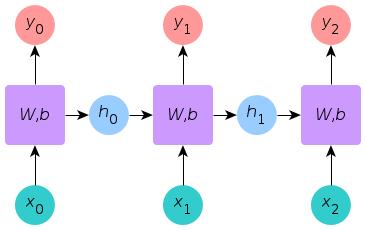

### Exploding and vanishing gradients

The main disadvantage of RNN is slow training when the input sequences are long. 

Moreover for a long input sequences gradient exploding or vanishing can occur.

Let us see how it happens. 

Mathematically operation of RNN can be represented as a nested function. In the very simplified form it looks as follows:

$$
y_1 = F(x_1, w)
$$

$$
y_2 = F(F(x_1, w), w)
$$

$$
y_3 = F(F(F(x_1, w), w), w)
$$

These formulas are not exact. We omit here passing new input elements $x_2$ and $x_3$ and also assume that $y_t=h_t$. These formulas are needed only to illustrate an idea.

Let us now compute gradient. For our example it will be derivative of $y_t$ at $w$. Consider $y_2$:

$$
\frac{d y_2}{d w} = F'_w(\ldots) + F'_x(\ldots) F'_w(\ldots)
$$

What is important is the we have multiplication of two terms: $F'_x(\ldots) F'_w(\ldots)$. For $y_t$ we will have multiplication of $t$ terms.

Long multiplication series in numerical computations usually behave bad. Just imagine we have a sequence

$$
A = a_1 a_2 a_3\ldots a_n$
$$

If most of $|a_i|>1$ the result $A$ will go to infinity when $n$ grows. And if most of $|a_i|<1$ the result tends to zero.

It often happens when an RNN is trained. In principle this problem also appears when we train ordinary neural network with many layers. 

One technique for preventing the exploding gradient problem is called gradient clipping: too large gradients are just clipped.

The vanishing is can be prevented by adding more direct backward connections between end and beginning of the network.

### LSTM and GRU

Usually today pure RNN are not used due to problems with vanishing gradients and decaying information along a sequence.

Popular architecture of recurrent networks instead of RNN is called LSTM, Long Short-Term Memory. 

At every stage an LSTM unit decides what to keep in memory and what to discard. 

LSTM unit has rather sophisticated inner structure and a lot of trainable parameters. 

GRU, Gate Recurrent Unit, is a simplified version of LSTM. Typically it performs as good as LSTM but has less number parameters to train.

### Deep recurrent networks

Recurrent network can be deep. This is by considering outputs at each iteration as another sequence that goes to another recurrent layer.

Deep recurrent networks can be useful when some complex relationships in text have to be captured.

A figure below show three stacked recurrent layers.

The output of the recurrent network is usually processed further with dense layers. 

Depending on the problem setup we can take for the further processing either the last output $y_t$ or the whole sequence $y_0$, $y_1$, ..., $y_t$.

![rnn-deep.png](fig/rnn-deep.png)
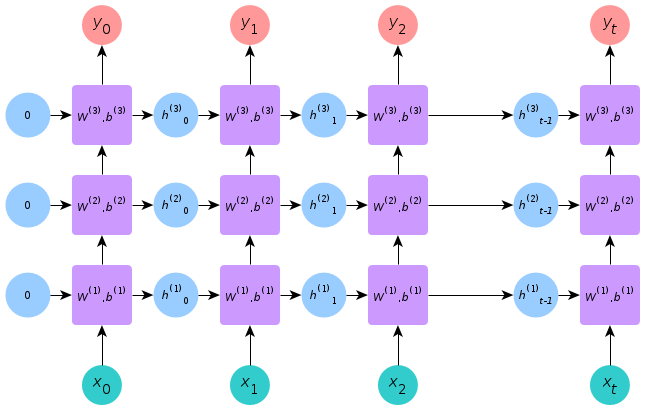

### Text preprocessing and vectorization for recurrent network

Before dealing with the network a text has to be preprocessed and vectorized.

Usually we do some cleaning and word normalization at first place. 

Specific feature of the recurrent networks is capturing dependencies of words, how they go one after another.

It means that stemming and lemmatization are unwelcome. Converting words to their base form removes important information about word connection.

Vocabulary of a text without normalization becomes huge and using word embedding like word2vec becomes absolutely necessary. 

Also stopwords removal, if done at all, must be done with a grate care. All words in a sentence are essential for building their structure. 

In the example below we will remove only articles "a", "an" and "the" because our model will be not so perfect to capture their meaning correctly. But perhaps even the articles can be left in the text.

Standard steps after text preprocessing is its tokenization, building vocabulary and assigning an integer number to each token from the the vocabulary. 

Then tokens in sentences are change to their numbers.

Now instead of sentences we have sequences of integers. But these integers are categorical data. We cannot manipulate with as do with usual numbers. Standard next step is to convert these number into one-hot vectors and the create Bag of Words or TF-IDF representation of sentences. 

However as we have mentioned above this is not appropriate due to huge vocabulary. The vectors will be very high dimensional. The preferred way is to convert one-hot vectors into compact meaningful vectors via embedding. 

This can be done with either pretrained model as we discussed previously or we can use special `tensorflow` layer `Embedding`. Its input are sequences of integers and its output are sequences of embedding vectors. 

This layer encapsulates a simple network that is trained simultaneously with other layers of the whole network.

### Proverbs generation with recurrent network

In this example we will create a model that will be able to generate proverbs and phrases.

The training dataset is takes from Kaggle https://www.kaggle.com/bryanb/phrases-and-sayings and copied to the course repository for convenience.

Below is the function that downloads zipped csv-file and opens it.

In [ ]:
import csv
import requests
from io import BytesIO, TextIOWrapper
from zipfile import ZipFile

def load_zipcsv_categorical(file_name):
    """Downloads zipped csv dataset from repo and return it as a nested list."""
    base_url = "https://raw.githubusercontent.com/kupav/data-sc-intro/main/data/"
    web_data = requests.get(base_url + file_name)
    assert web_data.status_code == 200

    # unzip the content
    zf = ZipFile(BytesIO(web_data.content))
    
    # zipped file name
    zipped_name = zf.namelist()[0]
    print(f"Download {file_name}, unzip {zipped_name}")
    
    # Open unpacked file
    with zf.open(zipped_name, 'r') as file:
        # TextIOWrapper(file) converts byte strings to plain strings
        reader = csv.reader(TextIOWrapper(file), delimiter=',')
        data = []
        for row in reader:
            data.append(row)
    return data

raw_data = load_zipcsv_categorical("proverbs.zip")

Here are the raw data from the downloaded file:

In [ ]:
print(len(raw_data))
for s in raw_data[:10]:
    print(s)

We see that there are three columns. We need the second one.

While extracting the data we will ignore too short phases. Only those that have 5 or more words are preserved.

In [ ]:
SMALLEST_PHRASE = 5

all_proverbs = [row[1] for row in raw_data[1:] if len(row[1].split()) >= SMALLEST_PHRASE]
print(len(all_proverbs))
for s in all_proverbs[:10]:
    print(s)

The number of phrases is very big. An as we will see below generating training samples enlarges the dataset even more. 

We take only 150 records to avoid the out of memory error.

Before taking the phrases we need to shuffle the dataset since it is ordered alphabetically.

In [ ]:
N_LIMIT = 150

import numpy as np
rng = np.random.default_rng(seed=1)

proverbs = all_proverbs.copy()

rng.shuffle(proverbs)
proverbs = proverbs[:N_LIMIT]
print(proverbs[:50])

This is data cleaning and tokenization routine. 

We remove only articles "a", "an", "the" and all punctuation marks.

In parallel we collect unique tokens to have a vocabulary. 

Notice that we insert to the vocabulary a special token `<pad>` at the first position. 
    
This is because we will pad too short sentences with zeros thus zero must not correspond to any meaningful token.

In [ ]:
import re
import nltk
nltk.download('punkt')  # Reqired by tokenizer if executed in Colab
DELIM = '<pad>'  # Marker of padding zeros

def tokenize(corpus):
    """Lowering case and tokenization. Also remove punktuation
    """
    stop = ['a', 'an', 'the']
    punkt = '.,:;!?/\(){}[]-'
    unique = set()
    tokenized_corpus = []
    for doc in corpus:
        tokens = nltk.word_tokenize(doc.lower())
        tokens = [tok for tok in tokens if tok not in stop and tok not in punkt]
        tokenized_corpus.append(tokens)
        unique.update(tokens)
        
    unique = list(unique)
    # now add delimiter as a special token 
    # that correspons to padding zero
    unique.insert(0, DELIM)  
    return tokenized_corpus, unique

The list of phases is converted to list of list of tokens.

In [ ]:
tokenized_corpus, unique_tokens = tokenize(proverbs)
length_of_unique_words = len(
    unique_tokens)
print(unique_tokens[:5])
print(tokenized_corpus[:5])

See what is the size of the vocabulary.

In [ ]:
print("Vocabulary size =", length_of_unique_words)

This function below enumerates all tokens and creates two dictionaries. 

The first converts token to its number and the second finds the token for the given number.

Such dictionaries are also called lookup tables.

In [ ]:
def build_indices(unique):
    word_to_idx = {}
    idx_to_word = {}
    for i, word in enumerate(unique):
        word_to_idx[word] = i
        idx_to_word[i] = word
    return word_to_idx, idx_to_word

Create the dictionaries. Check that the padding symbol has number zero.

In [ ]:
word_to_idx, idx_to_word = build_indices(unique_tokens)

# zero corresponds to the delimiter
print(f"Number of padding token {DELIM}: ", word_to_idx[DELIM])
print(f"Token with number 0: ", idx_to_word[0])  

Now we prepare the taring sequences.

It looks like this: we take two tokens from a sentence. The first is a training sequence (of length 1) and the second is the expected result. 

Then we take the first three tokens, previous two and one more. The first two now is the training sequence and the last one is the expected result.

That is how the sentence "Imitation is the sincerest form of flattery" is transformed into training sequences (article "the" has been removed):

- Imitation $\to$ is
- Imitation is $\to$ sincerest
- Imitation is sincerest $\to$ form
- Imitation is sincerest form $\to$ of
- Imitation is sincerest form of $\to$ flattery

The function below does the job. But it operates with token numbers instead of the tokens themselves and does not split the sequences into training and testing. Actually each sentences is merely converted into a set of sequences:

- Imitation is
- Imitation is sincerest
- Imitation is sincerest form
- Imitation is sincerest form of
- Imitation is sincerest form of flattery

In [ ]:
def prepare_sequences(corpus, word_to_idx):
    sequences = []
    for line in corpus:
        tokens = line
        for i in range(1, len(tokens)):
            i_gram_sequence = tokens[:i+1]
            i_gram_sequence_ids = []
            
            for token in i_gram_sequence:
                i_gram_sequence_ids.append(word_to_idx[token])
                
            sequences.append(i_gram_sequence_ids)
    
    return sequences

In [ ]:
sequences = prepare_sequences(tokenized_corpus, word_to_idx)
max_sequence_len = max([len(x) for x in sequences])
print("Total number of sequences =", len(sequences))
print("max_sequence_len =", max_sequence_len)

Here is the example how sequences looks.

In [ ]:
for seq in sequences[:16]:
    print(seq, end=":  ")
    for s in seq:
        print(idx_to_word[s], end=" ")
    print()

All created sequences have different lengths. But the model will expect sentences of the fixed size. 

Thus we need padding. This problem is typical for text processing and `tensorflow` provides a special function `pad_sequences` for it.

This is an example how it works. Observe that in the last statement we specify parameter `maxlen`. This is total size of the resulting sequences.

If we omit it the sequences will have the size equals to the longest sequence.

In [ ]:
s = [[1], [2, 3], [4, 5, 6], [7,8,9,10]]
print(pad_sequences(s))
print(pad_sequences(s, maxlen=6))

Padding with zero looks not so good because some samples will be without zeros at all and others will have a lot of preceding zeros. 

To make equalize conditions for all we add three zeros more to each sequences. 

Intuition behind it is as follows: Samples with and without padding can probably influence the training process differently. But this is not so important whether we have three zeros in the beginning or more.

After the padding the function below extracts the last column of the resulting array. This column is returned as targets (the expected predictions) and the rest is the taring sequences.

The targets are converted into one-hot form using `tensorflow` function `to_categorical`

In [ ]:
import numpy as np

def build_input_data(sequences, length_of_unique_words, maxlen):
    sequences = np.array(pad_sequences(sequences, maxlen=maxlen))
    X = sequences[:,:-1]
    y = sequences[:,-1]
    y = tf.keras.utils.to_categorical(y, length_of_unique_words)
    return X, y

In [ ]:
MORE_ZEROS = 3
max_sequence_len_fixed = max_sequence_len + MORE_ZEROS

X, y = build_input_data(sequences, length_of_unique_words, max_sequence_len_fixed)
print("Training sample example:\n", X[3])
print("Corresponding target:\n", y[3])

These are finally trainng data and the corresponding targets.

In [ ]:
print(X.shape)
print(y.shape)

We a ready to create a model. It will be the simplest one.

Observe that the first layer performs embedding and produces 10 dimensional vectors representing tokens.

After that the LSTM unit goes. Its parameter 128 means that its output is a vector of 128 elements.

Notice that by default LSTM and all other recurrent units of `tensorflow` return only the final output $y_t$ corresponding to the last element of the input sequence.

This output is further passed to dropout and dense layer whose number of output element equals to the size of the vocabulary. 

The network output is a number of token in the vocabulary.

Since we need to predict categorical data the categorical cross entropy is used as a loss function. And as usual Adam is used as optimizer.

In [ ]:
# Switch to CPU if is lacking of GPU memory  

#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [ ]:
model1 = Sequential([
    Embedding(length_of_unique_words, 10, input_length=X.shape[1]),
    LSTM(128),
    Dropout(0.6),
    Dense(length_of_unique_words)
])

model1.compile(optimizer='adam', loss=CategoricalCrossentropy(from_logits=True))

model1.summary()

In [ ]:
hist = model1.fit(X, y, batch_size=256, epochs=300)

When model is trained we can test it. 

The function below generate texts using the seed. It takes `seed_text` as a parameter and a number of words to generate.

At each iteration it takes the current seed text, converts it to a sequences of token numbers,
then pad it with zeros and pass it to the model. 

The model returns a token number, function `np.argmax` reveals it. Then the number is converted to a token that is appended to the seed_text. And new iteration starts.

In [ ]:
def generate_text(seed_text, next_words, model, max_seq_len):
    for _ in range(next_words):
        tokens, _ = tokenize([seed_text])
        sequence = [word_to_idx[w] for w in tokens[0]]  # sequence of token numbers
        sequence = pad_sequences([sequence], maxlen=max_seq_len-1)
        predicted = model.predict(sequence, verbose=0)
        output_word = ''
        output_word = idx_to_word[np.argmax(predicted[0])]            
        seed_text = seed_text + " " + output_word
        
    return seed_text

In [ ]:
print(generate_text("big bird", 8, model1, max_sequence_len_fixed))

In [ ]:
print(generate_text("may i", 8, model1, max_sequence_len_fixed))

In [ ]:
print(generate_text("hat is big", 8, model1, max_sequence_len_fixed))

In [ ]:
print(generate_text("kingdom", 8, model1, max_sequence_len_fixed))

Now we consider how to create deep recurrent network. 

All inner recurrent layers must return their outputs at each time step to send them forward to another recurrent layer. 

For this purpose we set `return_sequences=True` for the first LSTM layer (its default value was `False`)

Then we can add one more LSTM layer. 

Since we have two layers let us try to decrease their dimensions: from 128 above to 64 each now. 

The number of trainable parameters has became smaller in comparison with the first model.

In [ ]:
model2 = Sequential([
    Embedding(length_of_unique_words, 10, input_length=X.shape[1]),
    LSTM(64, return_sequences=True),
    LSTM(64),
    Dropout(0.6),
    Dense(length_of_unique_words)
])

model2.compile(optimizer='adam', loss=CategoricalCrossentropy(from_logits=True))

model2.summary()

In [ ]:
hist = model2.fit(X, y, batch_size=256, epochs=300)

In [ ]:
print(generate_text("big bird", 8, model1, max_sequence_len_fixed))
print(generate_text("big bird", 8, model2, max_sequence_len_fixed))

In [ ]:
print(generate_text("may i", 8, model1, max_sequence_len_fixed))
print(generate_text("may i", 8, model2, max_sequence_len_fixed))

In [ ]:
print(generate_text("hat is big", 8, model1, max_sequence_len_fixed))
print(generate_text("hat is big", 8, model2, max_sequence_len_fixed))

In [ ]:
print(generate_text("kingdom", 8, model1, max_sequence_len_fixed))
print(generate_text("kingdom", 8, model2, max_sequence_len_fixed))

We observe that our model can produce something reasonable. 

But let us not forget that in fact we train it to reproduce only grammatical rules. 

It can not catch meaning of a text and generate something sensible.

We have provided two versions of the model. It can be further improved. 

Probably it is worth to try to keep even articles. May be in their presence generated text will be more correct.

One more parameter to change is the size of the corpus. Above we have trained the models using its short part. If there is enough memory the size can be enlarged.

We restrict ourselves with phrases of 5 and more tokens. May be that was wrong. Mays be short phrases have more pronounced word connections and training on them can improve model performance.

Also the network structure can be modified. More layers can be added and their dimensions can be varied.

Dropout is very essential. Absent or low dropout results in networks that tend to repeat one word.

Two other units can be tested: `SimpleRNN` and `GRU` (in `tensorflow` the class that creates a plain RNN unit is called `SimpleRNN` while the class `RNN` is the base class for all recurrent units). Maybe some of them will perform the same or even better.

More dense layers can be added after the recurrent layers. 

One more interesting idea to try: to add `return_sequences=True` to the last recurrent layer and then add a convolution followed by a pulling. 

Finally instead of trainable `Embedding` layer the pretrained embedding model can be used, e.g. word2vec. May be the information about word relations obtained at huge text corpora will be useful for our models.

### Exercises

1\. Following the recommendations provided at the end of the section "Dense network for document classification" try to improve the model from this section.

2\. Following the recommendations provided at the end of the section "Convolutional network for document classification" try to improve the model from this section.

3\. Following the recommendations provided at the end of the section "Proverbs generation with recurrent network" try to improve the model from this section.